# Documentation

Todo: add details on what is digit in noise, how is it measured, why is it easy to measure?

**Background on CCA:** Canonical Correlation Analysis is a statistical method used to analyze the relationship between two sets of variables. It identifies pairs of canonical variables—one from each set—that are maximally correlated with each other. CCA seeks to find the linear combinations of variables in each dataset such that the correlations between these combinations are maximized. This technique is widely used to understand the relationships between two sets of variables and to explore the data structures from multiple datasets simultaneously.

**Progress:** To fully understand how CCA works, we attempted to conduct CCA by hand. Our by hand process may not be exactly the same as CCA from pre-written packages, such as sklearn. The steps of the by hand process is listed below.

The general motivation is to predict measurements in an audiogram with features, such as gender, age, digit in noise, which can be more easily obtained than directly measuring for an audiogram.

We have seen previously that the measurements in the audiogram are highly correlated with each other, and it is possible to reduce the dimension of the measurements without losing much information, making prediction easier.

In this file, we try to write out an algorithm that follows the above idea.

We also try to answer the question -- can we add one or two measurements in the audiogram as predictors to improve the predicting performance? If so, which ones?

**Result/Next step:** We don't observe obvious improvement in model performance when additional predictors are added. We need to further validate whether the model is learning the actual relationship.

# Work

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 Load in our previously exported dataset of intersted features... since we would want to include digit in noise this time.

In [ ]:
interest = pd.read_csv('/content/drive/MyDrive/UW/sphscAudiogram/audiogram_interest.csv')

**Clean the dataset again using similar process as before.**

Drop rows with na's in our interested columns, and drop uninterestd columns.

In [ ]:
# cca_clean: cleaned dataset for cca
cca_clean = interest.dropna(subset = ['AGE', 'LT1', 'RT1', 'GENDER']).drop(columns =
 ['RPTA3', 'RPTA4', 'LPTA3', 'LPTA4', 'PTA3mean', 'PTA4mean', 'VOLUME SETTING', 'TotDur1', 'LD1', 'RD1'])

Get dummy variables for gender.

In [ ]:
# cca_gender_dummies: dummy variables for gender
cca_gender_dummies = pd.get_dummies(cca_clean['GENDER'], prefix='GENDER')
cca_gender_dummies['GENDER_Female'] = cca_gender_dummies['GENDER_Female'].astype(int)
cca_gender_dummies['GENDER_Male'] = cca_gender_dummies['GENDER_Male'].astype(int)

In [ ]:
# cca: X and Y for cca in single dataframe
cca = pd.concat([cca_clean, cca_gender_dummies], axis=1).drop(columns = ['GENDER'])

Check for any na.

In [ ]:
cca[cca.isna().any(axis=1)]

,AGE,R250,R500,R1000,R2000,R3000,R4000,R6000,R8000,L250,...,L1000,L2000,L3000,L4000,L6000,L8000,LT1,RT1,GENDER_Female,GENDER_Male


Replace 'nr' with max volume.

In [ ]:
cca = cca.replace(to_replace=r'(?i)nr', value=110, regex=True)

**Export data**

In [ ]:
cca.to_csv('/content/drive/MyDrive/UW/sphscAudiogram/audiogram_cca.csv', index=False)

**Define our predictors.**

In [ ]:
# cca_predictors: predictors to predict the audiogram measurements
cca_predictors = ['AGE', 'GENDER_Female', 'GENDER_Male', 'LT1', 'RT1']

Recall that we are trying to predict the audiogram measures with age, gender, digit in noise

In [ ]:
# X: predictor columns of the cleaned dataframe for cca use
# Y: columns we want to predict of the cleaned dataframe for cca use
X = cca[cca_predictors]
Y = cca.drop(columns = cca_predictors)

In [ ]:
Y

,R250,R500,R1000,R2000,R3000,R4000,R6000,R8000,L1000,L2000,L3000,L4000,L6000,L8000
0,0.0,0.0,5.0,15.0,10.0,0.0,5.0,15,5.0,15.0,20.0,5.0,5,15
1,25.0,35.0,40.0,30.0,35.0,40.0,55.0,40,35.0,30.0,25.0,30.0,30,45
2,35.0,30.0,35.0,40.0,55.0,60.0,70.0,80,15.0,5.0,35.0,45.0,50,85
3,10.0,20.0,5.0,15.0,10.0,15.0,25.0,15,0.0,15.0,15.0,20.0,35,15
4,45.0,45.0,40.0,45.0,60.0,70.0,95.0,95,30.0,40.0,45.0,55.0,100,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,10.0,15.0,15.0,20.0,35.0,30.0,65.0,70,20.0,15.0,15.0,40.0,75,95
263,10.0,15.0,10.0,5.0,20.0,25.0,15.0,20,15.0,10.0,20.0,25.0,15,20
264,20.0,25.0,30.0,30.0,35.0,40.0,50.0,65,25.0,25.0,30.0,40.0,45,50
265,15.0,5.0,15.0,20.0,20.0,25.0,30.0,35,10.0,10.0,15.0,15.0,30,35


**Scale X and Y.**

In [ ]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()
x_scaler.fit(X)
y_scaler.fit(Y)
scaled_X = pd.DataFrame(x_scaler.transform(X), columns = X.columns)
scaled_Y = pd.DataFrame(y_scaler.transform(Y), columns = Y.columns)

**Note:** We want to scale X and Y separately, since in practice, Y is unseen data, we wouldn't be able to scale X with a scaler that is fitted on both X and Y

**Split data for training and testing later.**

In [ ]:
X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled = train_test_split(scaled_X, scaled_Y, test_size=0.2, random_state=6)

**Fit a pca with 5 components.**

Define n_components for easy modification in number of components we want to use

In [ ]:
n_components = 5

In [ ]:
# Y_train_pca: 5-component pca transformed scaled Y_train
pca = PCA(n_components=n_components, random_state=0)
pca.fit(Y_train_scaled)
Y_train_pca = pca.transform(Y_train_scaled)

In [ ]:
pd.DataFrame(Y_train_pca)

,0,1,2,3,4
0,-1.865251,-1.000006,0.086690,-0.602197,-0.758542
1,1.116757,-1.121399,-0.784483,0.952609,-0.097987
2,-3.283512,-0.124824,-0.109078,0.790628,-0.547114
3,3.483020,-1.309827,0.276637,-0.979855,-0.517209
4,5.183652,1.666385,2.307351,-0.418133,0.172463
...,...,...,...,...,...
201,2.372649,0.685884,0.176886,0.156739,0.260781
202,4.390335,-0.594551,-0.597531,1.287091,-0.268399
203,0.221861,-1.516679,1.413037,-0.000443,0.424562
204,-2.770470,-0.257088,0.525812,-0.125934,0.054299


### CCA By Hand

**Note:** This by hand process generally follows the idea of a CCA, but is not exactly CCA, and is slightly different from directly using CCA package from sklearn.

Steps:

1. Split data into X, Y
2. Scale X, Y separately
3. Split X, Y into train and test set
4. Transform Y_train into principle components
5. Fit a separate OLS model, using entire X_train_scaled to predict each of the n principle components of Y_train
6. Use each model to predict each of the n principle components of Y_test from X_test_scaled
7. Reconstruct predictions back to original data scaling
8. Compute rmse (or any accuracy measuring metric)



In [ ]:
'''
Inputs
n_comp: number of components used in pca
X_train_scaled: scaled X_train
Y_train_pca: pca transformed scaled Y_train
X_test_scaled: scaled X_test
Y_test_scaled: scaled Y_test
pca: the pca object used to transform Y_train
y_scaler: the scaler object used to transform Y

Returns the predicted Y_test, and the rmse of the prediction.
'''
def predict_pca(n_comp, X_train_scaled, Y_train_pca, X_test_scaled, Y_test_scaled, pca, y_scaler):
  # predicted_pca: dictionary to store linear regression's prediction of pca, with the ith component at index i
  predicted_pca = {}
  rmse = 0
  for i in range(0, n_comp):
    # fit OLS model on scaled X_train vs pca transformed scaled Y_train
    lm = LinearRegression()
    lm.fit(X_train_scaled, pd.DataFrame(Y_train_pca)[i])

    # attach the predicted principle components of Y_test to predicted_pca
    predicted_pca[i] = lm.predict(X_test_scaled)

  # predictions_reconstructed_to_scaled: recontructed pc prediction of Y_test, now in the version of Y_test_scaled
  predictions_reconstructed_to_scaled = pca.inverse_transform(list(zip(*predicted_pca.values())))

  # Y_test_predicted: predictions_reconstructed_to_scaled in original data scaling
  Y_test_predicted = y_scaler.inverse_transform(predictions_reconstructed_to_scaled)

  # calculate rmse of the actual Y_test and the predicted Y_test
  rmse = root_mean_squared_error(Y_test_predicted, y_scaler.inverse_transform(Y_test_scaled))

  return Y_test_predicted, rmse

In [ ]:
# calling predict_pca on our previously prepared data with 5 component pca
Y_test_predicted, rmse = predict_pca(5, X_train_scaled, Y_train_pca, X_test_scaled, Y_test_scaled, pca, y_scaler)

In [ ]:
rmse

13.33869152970587

This RMSE is on a scale of 110 Db, which is not bad. But we should make further validation that our model is actually working.

**Reconstruct the pca dataframe to original data, and compare the loss**

In [ ]:
pd.DataFrame(Y_test_predicted).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,16.639924,17.516542,22.874707,33.236536,44.828606,51.837320,60.757567,68.931577,12.420708,14.791918,20.172125,31.894870,43.722335,50.288096,59.081529,65.263936
1,14.224585,17.116218,21.030814,25.718797,33.386371,40.093592,51.677411,61.918495,13.231940,17.186874,20.803713,26.825121,35.442784,43.039326,53.455506,61.849516
2,20.954828,25.049782,31.381519,40.200630,48.222367,53.374404,61.333135,68.309573,19.704758,24.238162,30.317475,41.232889,49.400395,54.604542,61.746822,68.200455
3,13.059356,15.702595,19.579148,23.544899,29.341053,34.558240,43.045546,50.525448,14.032340,16.974078,20.294214,26.239188,33.189427,39.017366,46.686331,53.050858
4,12.185454,12.039024,16.135061,23.496130,32.718186,38.668161,45.684966,52.110361,9.948407,10.725355,14.418440,23.490557,33.497098,39.163765,46.321889,50.991717


In [ ]:
pd.DataFrame(y_scaler.inverse_transform(Y_test_scaled)).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,15.0,25.0,35.0,60.0,70.0,75.0,80.0,90.0,15.0,20.0,25.0,55.0,65.0,70.0,75.0,75.0
1,20.0,20.0,10.0,15.0,35.0,30.0,30.0,60.0,25.0,15.0,15.0,25.0,25.0,30.0,25.0,35.0
2,30.0,35.0,50.0,45.0,45.0,45.0,55.0,65.0,40.0,40.0,40.0,50.0,40.0,50.0,60.0,70.0
3,5.0,0.0,5.0,10.0,5.0,5.0,15.0,30.0,5.0,5.0,5.0,15.0,10.0,15.0,20.0,45.0
4,50.0,45.0,50.0,70.0,60.0,75.0,70.0,65.0,35.0,40.0,50.0,55.0,55.0,65.0,65.0,60.0


**Observation:** Some predictions are very off, while others are decently close to the actual data.

Since the audiogram measurements are highly correlated with each other, can we somehow determine which predictions are more accurate, and smooth the other features in the audiogram based on their relationship with that most accurate column's prediction?

**Visualize prediction vs actual**

Red line represents where the perfect prediction should lie.

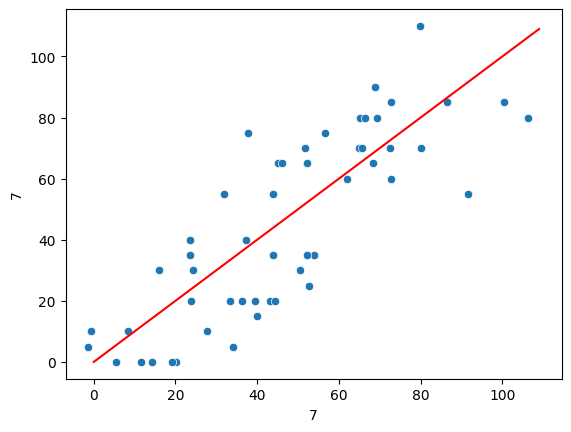

In [ ]:
sns.scatterplot(x = pd.DataFrame(Y_test_predicted).iloc[:,7], y = pd.DataFrame(y_scaler.inverse_transform(Y_test_scaled)).iloc[:,7])
plt.plot(np.arange(0, 110), np.arange(0, 110), color='red', linestyle='-')
plt.show()

**Observation:** The points are not too far away from the perfect fit. If we plot some sort of confidence interval band, it is likely that most fall within.

How can we narrow the distance that the points lie away from the line? I.e, improve the prediction performance?

### Which additional feature can we add to reduce the loss?

Now that we see the general performance of using age, gender, DIN to predict audiogram measurements, can we measure one or two measurements in the audiogram to improve the predicting performance? If so, which ones?

In [ ]:
# features: audiogram measurements we are prediciting
features = ['L250', 'L500', 'L1000', 'L2000', 'L3000',
       'L4000', 'L6000', 'L8000', 'R250', 'R500', 'R1000', 'R2000', 'R3000',
       'R4000', 'R6000', 'R8000']

In [ ]:
'''
Input
n_comp: number of components used for pca
cca: data with all X and Y columns
features: audiogram measurements we are interested in prediciting

Returns nothing
'''
def add_feature(n_comp, cca, features):

  # loop through all features
  for i in range(0, len(features)):
    feature = features[i]
    # print to help tracking
    print(feature)

    # add another loop to explore on adding second feature
    for j in range(i+1, len(features)):
      feature2 = features[j]

      # add feature1 and feature2 as predictors, and remove them from outcome
      predictors = ['AGE', 'GENDER_Female', 'GENDER_Male', 'LT1', 'RT1', feature, feature2]
      X = cca[predictors]
      Y = cca.drop(columns = predictors)

      # similar process as before -- scale, split, fit to pca
      x_scaler = StandardScaler()
      y_scaler = StandardScaler()
      x_scaler.fit(X)
      y_scaler.fit(Y)
      scaled_X = pd.DataFrame(x_scaler.transform(X), columns = predictors)
      scaled_Y = pd.DataFrame(y_scaler.transform(Y), columns = [p for p in features if p not in predictors])

      X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled = train_test_split(scaled_X, scaled_Y, test_size=0.2, random_state=6)

      pca = PCA(n_components=n_comp, random_state=0)
      pca.fit(Y_train_scaled)
      Y_train_pca = pca.transform(Y_train_scaled)

      # obtain Y test prediction and rmse with previously defined function predict_pca
      predicted, rmse = predict_pca(n_comp, X_train_scaled, Y_train_pca, X_test_scaled, Y_test_scaled, pca, y_scaler)

      # print second feature added, and the corresponding rmse
      print(feature2, rmse/n_comp)

**Note:** The rmse printed is the rmse from predict_pca divided by n_comp. So in the case of 5 components, we are comparing rmse of 14 from the base model, with, for instance, 2.67*5=13.35.

**How to read this outcome:**

Feature 1 [A] added

Feature 2 [B] added   rmse from adding feature [A] feature [B]

Feature 2 [C] added   rmse from adding feature [A] feature [C]

Feature 2 [D] added   rmse from adding feature [A] feature [D]

...

Feature 1 [B] added

Feature 2 [C] added   rmse from adding feature [B] feature [C]

...

In [ ]:
add_feature(5, cca, features)

L250
L500 2.6677383059411737
L1000 2.44796839420686
L2000 2.2163848061207374
L3000 2.104347301909113
L4000 2.2003254434184845
L6000 2.1607140804462386
L8000 2.2587853749977875
R250 2.703237667323166
R500 2.6002598732487425
R1000 2.5398572444134677
R2000 2.252259341170256
R3000 2.063191571437858
R4000 2.064605598656115
R6000 2.1480678304819745
R8000 2.2830331573668867
L500
L1000 2.439264369478391
L2000 2.184577716555391
L3000 2.022294915768037
L4000 2.10544348710219
L6000 2.0567596450898638
L8000 2.1357698768628763
R250 2.5946514759410855
R500 2.571179895534683
R1000 2.5347353491399343
R2000 2.2190867180812366
R3000 2.014427152921294
R4000 1.9944954631879903
R6000 2.057758388022603
R8000 2.162459470072249
L1000
L2000 2.2264538171165205
L3000 2.0306190315960566
L4000 2.089759711453013
L6000 2.014662804457748
L8000 2.088729593330732
R250 2.4413068363854653
R500 2.4395407434165683
R1000 2.5082004997481535
R2000 2.285930522582667
R3000 2.0516970062785846
R4000 2.004113723723049
R6000 1.9863

**Observation:** After taking a quick scan of all the rmse values, we can conclude that there are small variations in the rmse, but overall, not too much difference with what new features are included as predictors.

Moreover, there is no obvious improvements in the predictions even adding two measurements in the audiogram as predictors. This is surprising, since the measurements of the audiogram are highly correlated with each other, so theoretically, including even just a few measurements of the audiogram should significantly improve the model performance.

Therefore, we still need to validate furthermore whether the model is actually learning, or just making predictions randomly.